In [1]:
import json
import torch
import numpy as np
from collections import OrderedDict
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from utils.su_maps import get_su_values
from models import setup_model
from datasets import setup_dataset
%matplotlib nbagg

# Spatial uncertainty (SU) maps

This notebook shows how to generate spatial uncertainty maps for a cRNN trained on the incremental grouping task with EDL and C-RBP.

## Setting up

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setting up model
with open('results/hgru_grouping/opts.json', 'rb') as f:
    train_opts = json.load(f)  # get hyperparameters the model was trained with

model = setup_model(**train_opts)
checkpoint = torch.load('results/hgru_grouping/saved_models/model_acc_9757_epoch_24_checkpoint.pth.tar')
state_dict = checkpoint['state_dict']

if train_opts['parallel']:
    state_dict = OrderedDict([(k.replace('module.',''), v) for k, v in state_dict.items()])  

model.load_state_dict(state_dict)
model = model.eval()
model = model.to(device)

Init model hGRU  rbp penalty:  True steps:  40
Training with filter size: 5 x 5
37862


In [3]:
# Setting up dataset
datastr = 'cocodots_val_mini' if train_opts['dataset_str_val'].startswith('coco') else train_opts['dataset_str_val']
data_root = "./data/coco"
dataset = setup_dataset(datastr, data_root, subset=1, shuffle=False)
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)
iterator = iter(data_loader)

creating index...
index created!


In [4]:
# Get a batch
batch_dict = next(iterator)

## Run the model

In [5]:
i = 8

In [6]:
# Prepare inputs
img = batch_dict['image'][i]
fixation_x = batch_dict['fixation_x'][i]
fixation_y = batch_dict['fixation_y'][i]


uncertainties, cue_x, cue_y = get_su_values(img=img,
                                              model=model,
                                              fixation_x=fixation_x,
                                              fixation_y=fixation_y,
                                              device=device,
                                              batch_size=4)  
xi_crnn = np.trapz(uncertainties, axis=1)  # integrate

torch.Size([4, 150, 150])
(4, 150, 150)


## Plot SU Map

<IPython.core.display.Javascript object>


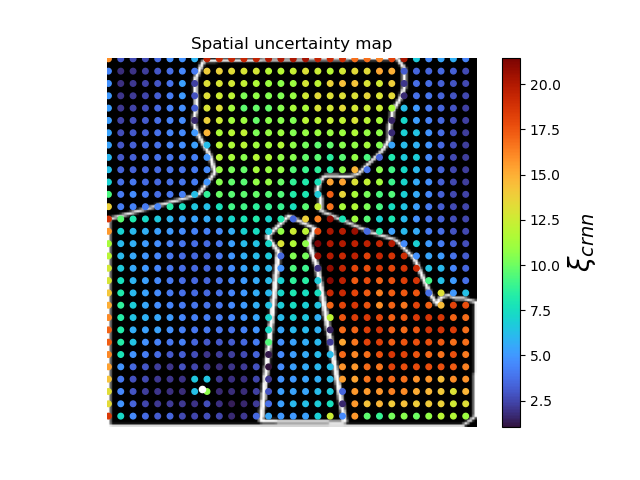

Text(0.5, 1.0, 'Spatial uncertainty map')

In [7]:
img_rgb = dataset.tensor_to_image(img, draw_dots=False)  # get the outline image

vmin = xi_crnn.min()
vmax = xi_crnn.max()
#vmin = 0.029817801  # minimum xi_crnn value across large random sample of validation stimuli
#vmax = 31.306564  # maximum xi_crnn value across large random sample of validaiton stimuli

#  Plot
plt.figure()
plt.imshow(img_rgb)  # draw outline
sc=plt.scatter(cue_x, cue_y, c=xi_crnn, cmap="turbo", s=16, vmin=vmin, vmax=vmax)  # draw cue dot at all probed positions
plt.scatter(fixation_x, fixation_y, color='white', s=20)  # draw fixation dot
cbar = plt.colorbar(sc)
cbar.set_label(r"$\xi_{crnn}$", size=20)
plt.axis('off')
plt.title('Spatial uncertainty map')